# Summing patch dynamics in the restricted path integral (RPI) approach

In this tutorial, we conduct the patch summation to compute the global population, using the RPI approach. We will use the patch dynamics computed in `19_step4_patch_rpi`. Thus, the patch dynamics data in the tutorial `19_step4_patch_rpi` are needed.

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
   
2. [Run the patch summation](#2)

3. [Plot populations](#3)

4. [Plot time-energy spectrograms](#4)

## A. Learning objectives
* To be able to conduct the patch summation to yield the population dynamics using the restricted path integral approach

## B. Use cases

* [Run NAMD simulations](#run_namd)
* [Plot results](#plot_res)

## C. Functions
- `libra_py`
  - `workflow`
    - `nbra`
      - `rpi`
        - [`run_sum`](#run_namd)
  - `units`
    - [`au2fs`](#run_namd)

## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

First, let's import all necessary libraries and define parameters such as colors

In [1]:
import os
import matplotlib.pyplot as plt   # plots
from matplotlib import cm
import numpy as np
import scipy.sparse as sp
from scipy.optimize import curve_fit
import h5py
import warnings

from liblibra_core import *
import util.libutil as comn
from libra_py import units, data_conv

from libra_py.workflows.nbra import rpi
import scipy.sparse as sp

#from matplotlib.mlab import griddata
%matplotlib inline 
#warnings.filterwarnings('ignore')

colors = {}
colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   
colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      
colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  
colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::allocator<float> >, std::allocator<std::vector<float, std::allocator<float> > > > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWar

## 2. Run the patch summation <a name="2"></a>
[Back to TOC](#toc)

We will use the patch dynamics data in `19_step4_patch_rpi`. The following parameters specify the RPI patch summation and the data to read.

* `nprocs`: The number of processors to be used.

* `nsteps`: The total number of RPI simulation steps

* `istate`: The initial state

* `nbatches`: The number of batches, i.e., the number of initial geometries you used in the previous patch dynamics calculation. This corresponds to `len(rpi_params["iconds"])`, where `rpi_params` is a previous patch-dynamics params.

* `npatches`: The number of patches.

* `nstates`: The number of electronic states.

* `dt`: the time step in the atomic unit.

* `path_to_save_patch`: The path of the precomputed patch dynamics

* `prefix_patch`: The prefix of patch dynamics directories

* `prefix`: The RPI output population prefix.

First, we need to extract the patch dynamics data.

In [2]:
! tar -xjf PATCH_DYN.tar.bz

Let's compute the global population with the patch dynamics data of `npatches = 2`.

In [3]:
rpi_sum_params = { 'nprocs': 2, 'nsteps': 50, 'dt': 1.0*units.fs2au, 'istate': 5, 'nbatches': 3, 'npatches': 2, 'nstates': 11, 
              'path_to_save_patch': 'PATCH_DYN', 'prefix_path':"out_", 'prefix': "POP_NPATCH_" }

rpi.run_sum(rpi_sum_params)
#rpi.run_sum_crude(rpi_sum_params) # less optimized, but easier to understand

Summing ipatch = 0, ibatch = 1Summing ipatch = 0, ibatch = 0

Summing ipatch = 1, ibatch = 1Summing ipatch = 1, ibatch = 0

Print the population from ibatch
Summing ipatch = 0, ibatch = 2
Print the population from ibatch
Summing ipatch = 1, ibatch = 2
Print the population from ibatch
Print the final population from all batches


The patch summation yields populations data. The population on a batch is given in `rpi_params["prefix"]X_ibatchY.dat`, where `X` becomes `rpi_sum_params["npatches"]`. `Y` runs from `0` to `len(rpi_params["iconds"]) - 1`. The final population from all batches is saved into `rpi_sum_params["prefix"]_all.dat`.

The global population from different number of patches can be computed. Let's compare the population from the patch dynamics data with `npatches = 10`.

In [4]:
rpi_sum_params.update({'npatches': 10})

rpi.run_sum(rpi_sum_params)

Summing ipatch = 0, ibatch = 0Summing ipatch = 0, ibatch = 1

Summing ipatch = 1, ibatch = 1Summing ipatch = 1, ibatch = 0

Summing ipatch = 2, ibatch = 1Summing ipatch = 2, ibatch = 0

Summing ipatch = 3, ibatch = 1Summing ipatch = 3, ibatch = 0

Summing ipatch = 4, ibatch = 1Summing ipatch = 4, ibatch = 0

Summing ipatch = 5, ibatch = 1Summing ipatch = 5, ibatch = 0

Summing ipatch = 6, ibatch = 0
Summing ipatch = 6, ibatch = 1
Summing ipatch = 7, ibatch = 0
Summing ipatch = 7, ibatch = 1
Summing ipatch = 8, ibatch = 0
Summing ipatch = 8, ibatch = 1
Summing ipatch = 9, ibatch = 0
Summing ipatch = 9, ibatch = 1
Print the population from ibatch
Print the population from ibatch
Summing ipatch = 0, ibatch = 2
Summing ipatch = 1, ibatch = 2
Summing ipatch = 2, ibatch = 2
Summing ipatch = 3, ibatch = 2
Summing ipatch = 4, ibatch = 2
Summing ipatch = 5, ibatch = 2
Summing ipatch = 6, ibatch = 2
Summing ipatch = 7, ibatch = 2
Summing ipatch = 8, ibatch = 2
Summing ipatch = 9, ibatch = 2
Prin

## 3. Plot populations <a name="3"></a>
[Back to TOC](#toc)

Let's plot the population dynamics. Changing the prefix, we can plot the population dynamics with different number of patches, `npatches`. The color code is from the `colors` dictionary, and the norm is shown in a black line. 

In [5]:
plt.rc('axes', titlesize=40)      # fontsize of the axes title
plt.rc('axes', labelsize=40)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=40)     # fontsize of the tick labels
plt.rc('ytick', labelsize=40)     # fontsize of the tick labels

plt.rc('figure.subplot', top=0.88)


font = {'family': 'serif',
        'color':  'blue',
        'weight': 'bold',
        'size': 36,
        }

In [6]:
def plot_population_data(filename):
    """
    Plot population dynamics from a file.    
    """
    # Load data
    data = []
    with open(filename, 'r') as f:
        for line in f:
            if line.strip():  # skip empty lines
                data.append([float(x) for x in line.strip().split()])
    data = np.array(data)

    # Extract time and populations
    time = data[:, 0]
    pops = data[:, 1:]

    # Plot
    plt.figure(figsize=(10, 6))
    for ist in range(pops.shape[1]):
        plt.plot(time*units.au2fs, pops[:, ist], label=f"State {ist}", color=colors[clrs_index[ist]], lw=5)

    plt.plot(time*units.au2fs, np.sum(pops, axis=1), label=f"Norm", color="k", lw=5)
    
    plt.xlabel("Time")
    plt.ylabel("Population")

    plt.legend()
    
    plt.show()

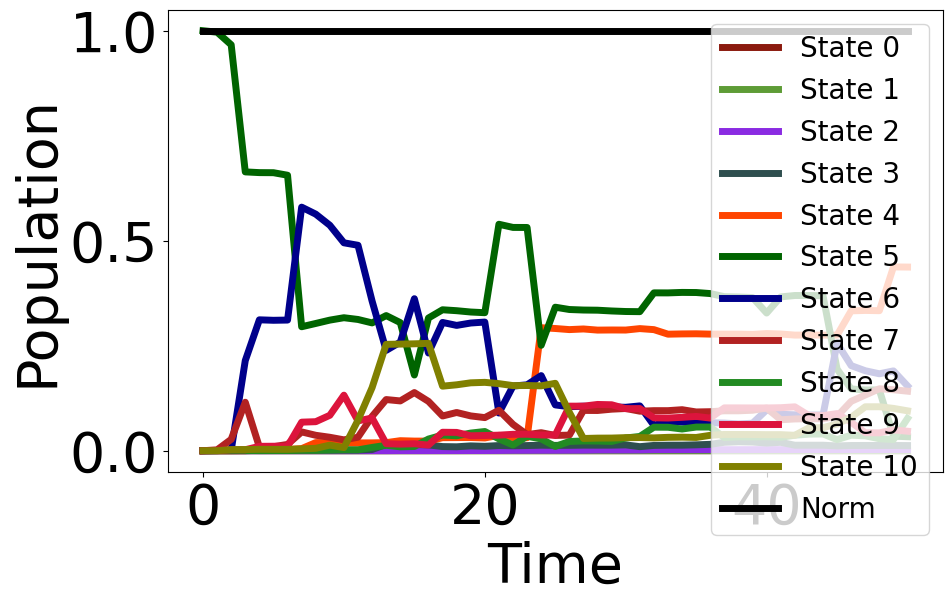

In [7]:
plot_population_data("POP_NPATCH_2_all.dat")

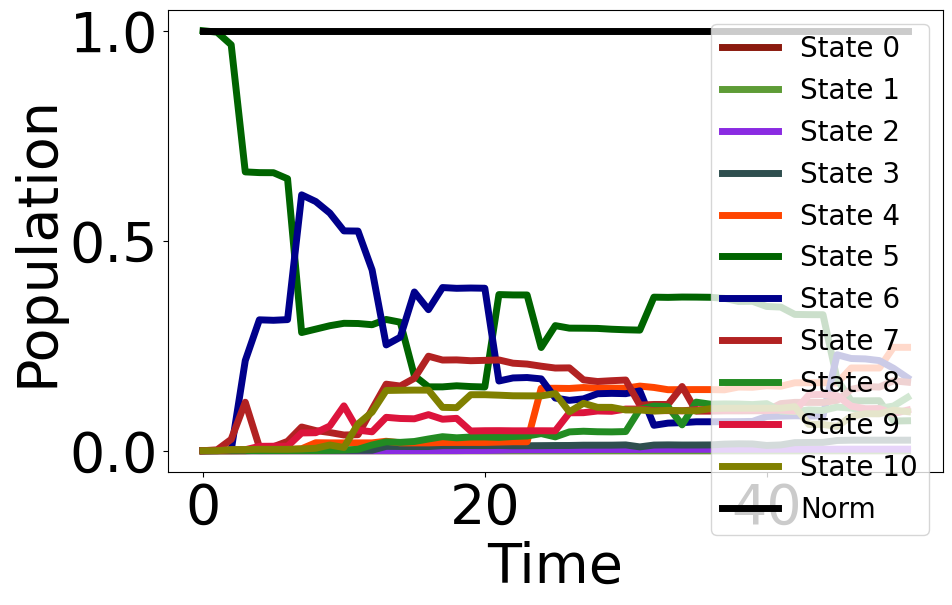

In [8]:
plot_population_data("POP_NPATCH_10_all.dat")

### Exercise 1
In this tutorial, the `rpi_params["istate"]` is set to `5`. Explore various initial states and see how the population dynamics differs.

### Exercise 2
How would the `npatches` affect the population dynamics? Along with `../19_step4_patch_rpi/`, test various `npatches` and compute the population dynamics.

## 4. Plot time-energy spectrograms <a name="4"></a>
[Back to TOC](#toc)

The population dynamics can be projected into the energy domain. The following function is for plotting the time-energy spectrogram from the RPI population. Consult with `../18_plotting_trpes` for the application to the NBRA-TSH calculations and more details.

In [9]:
## TRPES
def get_TRPES(trpes_params):
    # Read energies from the sampling first
    iread, fread = trpes_params["iread"], trpes_params["fread"]
    nst = trpes_params["nstates"]
    E = []
    for step in range(iread, fread):
        energy_mat = sp.load_npz(F"{trpes_params['path_to_save_Hvibs']}/Hvib_ci_{step}_re.npz")
        E.append( np.array( np.diag( energy_mat.todense() ) ) )
    E = np.multiply(E, units.au2ev)    
    
    # Compute the TRPES
    nsteps, npatches = trpes_params["nsteps"], trpes_params["npatches"]
    dt = trpes_params["dt"]

    nstep_patch = int(nsteps/npatches)
    time = np.array([x for x in range(npatches * nstep_patch + 1)]) * dt
    
    emin, emax = trpes_params["emin"], trpes_params["emax"] #eV
    de, sigma_e = 0.01, 0.1
    
    n_e_grid_pts = int((emax - emin)/de)+1
    
    t_grid = np.linspace(0, nsteps, nsteps)*(dt*units.au2fs)
    e_grid = np.linspace(emin, emax, n_e_grid_pts)
    
    TRPES = np.zeros((time.shape[0], n_e_grid_pts))
    TRPES_traj = np.zeros((time.shape[0], n_e_grid_pts))

    iconds = trpes_params["iconds"]
    for ibatch, icond in enumerate(iconds):
        rpi_pop = np.loadtxt(F"{trpes_params['prefix']}{npatches}_ibatch{ibatch}.dat")[:,1:]
            
        for i in range(time.shape[0]):
            for j, e_j in enumerate(e_grid):
                for ist in range(nst):
                    e = E[i + icond, ist]
                    smear = np.exp(-(e_j - e) ** 2) / (2 * sigma_e ** 2)
                    TRPES_traj[i, j] += rpi_pop[i, ist] * de * smear
        
        TRPES += TRPES_traj
    
    TRPES /= len(iconds)
    TRPES /= np.max(TRPES)
    
    return t_grid, e_grid, TRPES

Necessary parameters are below, which can be provided from the tutorials in `19_step4_patch_rpi` and `20_step5_sum_rpi` (this tutorial). Let `rpi_params` and `rpi_sum_params` be the parameters in Tutorials 19 and 20, respectively.

* `path_to_save_Hvibs`: The path of the vibronic Hamiltonian files (See `rpi_params["path_to_save_Hvibs"]`).

* `iread`: The initial step to read the vibronic Hamiltonian and time overlap (See `rpi_params["iread"]`).

* `fread`: The final step to read the vibronic Hamiltonian and time overlap (See `rpi_params["fread"]`).

* `iconds`: The list of initial step indices from the trajectory segment from iread to fread. Each initial condition characterizes each batch (See `rpi_params["iconds"]`).

* `nstates`: The number of electronic states (See `rpi_params["nstates"]` or `rpi_sum_params["nstates"]`).

* `dt`: the time step in the atomic unit (See `rpi_params["dt"]` or `rpi_sum_params["dt"]`).

* `prefix`: The RPI output population prefix (See `rpi_sum_params["prefix"]`).

* `emin`: the minimum energy of the energy grid

* `emax`: the maximum energy of the energy grid


We need to extract the data of vibronic Hamiltonian and time overlap.

In [10]:
! tar -xjf HS.tar.bz2

In [11]:
trpes_params = {'path_to_save_Hvibs': 'res-mb-sd-DFT', 
              'iread': 1200, 'fread': 1301, 'iconds': [0, 25, 50],
              'nsteps': 50, 'npatches': 10, 'nstates': 11, 'dt': 1.0*units.fs2au, 
              'prefix': 'POP_NPATCH_', 'emin': 2.0, 'emax': 8.0  
            }

In [12]:
t_grid, e_grid, TRPES_rpi = get_TRPES(trpes_params)

/tmp/ipykernel_215036/1494478091.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')


Text(0, 0.5, 'Energy (eV)')

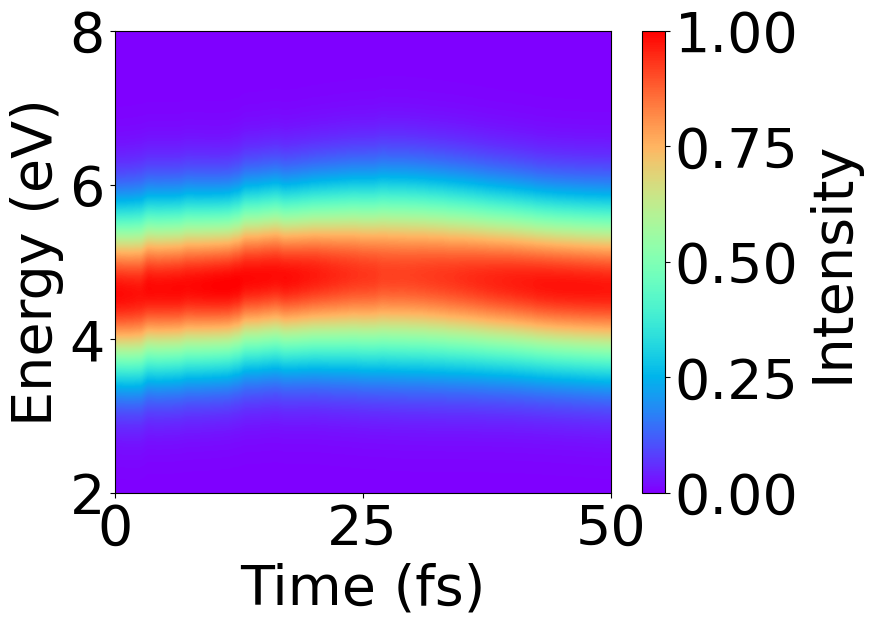

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

# E vs. t
cmap = cm.get_cmap('rainbow')
img = ax.imshow(TRPES_rpi.T, extent=[t_grid.min(), t_grid.max(), e_grid.min(), e_grid.max()],
                origin='lower', aspect='auto', cmap=cmap, vmin=0, vmax=1)

cbar = fig.colorbar(img, ax=ax, aspect=20, shrink=1.0)
cbar.set_label("Intensity", labelpad=5)

ax.set_xlim(t_grid.min(), t_grid.max())
ax.set_ylim(e_grid.min(), e_grid.max())

ax.set_xlabel("Time (fs)")
ax.set_ylabel("Energy (eV)")